## Jupyter Notebook to test prediction results

This scripts import the dataset then try to plot some results to 

1. Plot ground truth images 
2. Plot prediction images
3. Calculate R and P

### Prepatation

Data Import and Prepare

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import imageUtils
from utils import postProcessing
from utils import MultiDefectDetectionDataset
from utils import evaluation
from utils import visualization
import numpy as np
import os
from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#load Data
root = './data/Data3TypesYminXminYmaxXmax'
dataset = MultiDefectDetectionDataset(data_dir=root, split='train')
dataset_test = MultiDefectDetectionDataset(data_dir=root, split='test')
bbox_label_names = ('111loop', 'dot','100loop')

In [4]:
# DataSet Statistics
print('total number of training images: ', len(dataset))
print('total number of test images: ', len(dataset))
print('type of defects: ', bbox_label_names)

total number of training images:  70
total number of test images:  70
type of defects:  ('111loop', 'dot', '100loop')


### Show Data Set

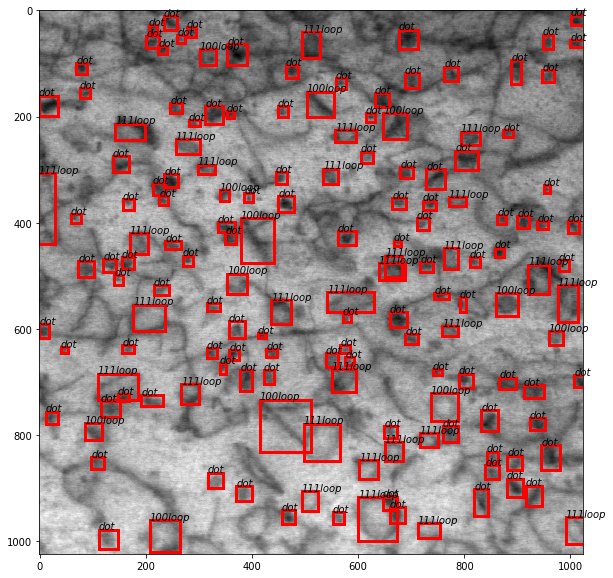

In [6]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[33]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()

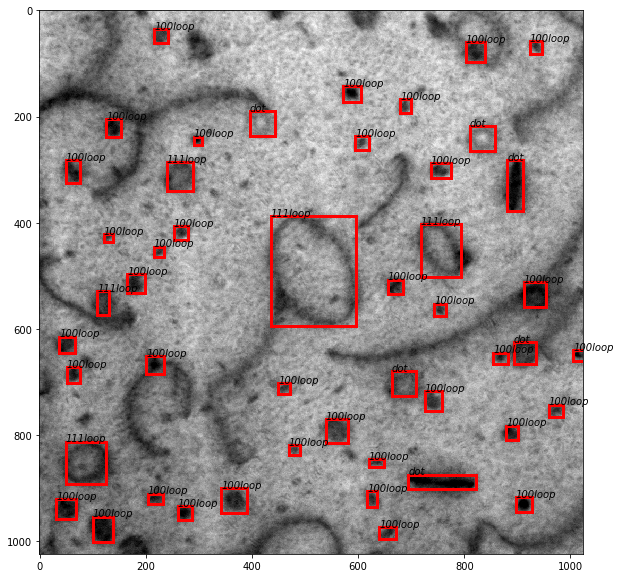

In [19]:
# Another Figure
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[50]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()

# Testing

Set `use_gpu = False` because we use CPU to do testing

In [24]:
use_gpu = False
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=3, pretrained_model='./modelResults/snapshot_model_56000_20180721.npz', ratios=[0.5, 1, 2],
                                  anchor_scales=[0.5, 1, 4, 8, 16], min_size=1024, max_size=1024,
                                  proposal_creator_params=proposal_params)
if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    
bbox_label_names = ('111loop', 'dot','100loop')

#### View Prediction Results

#### First figure

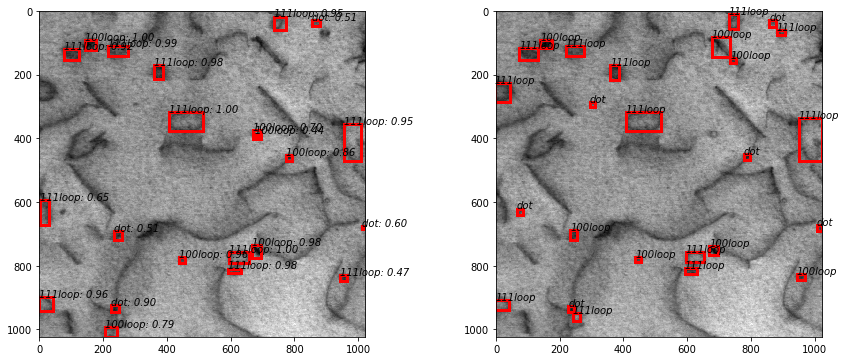

In [35]:
# Prediction of first image
img_1, bbs_1, lbs1 = dataset_test[1]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

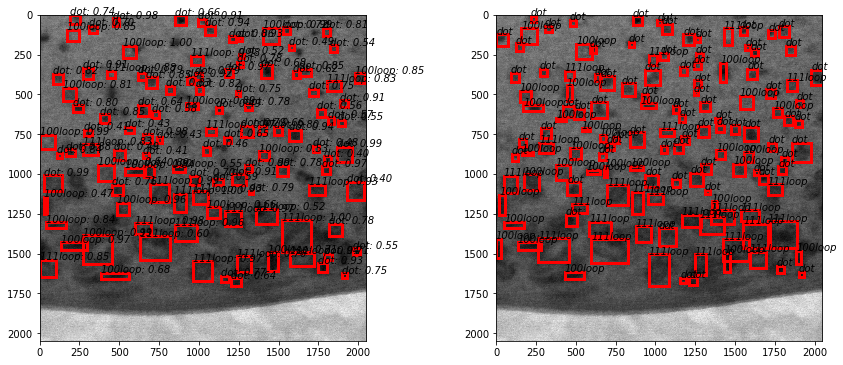

In [43]:
# Prediction of Second image
img_1, bbs_1, lbs1 = dataset_test[10]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

## Evaluation

In [7]:
from utils import evaluate_set_by_centroid
from utils import evaluate_set_by_centroid_kind
from utils import evaluate_set_by_defect_size
from utils import pr_plot_by_size

In [42]:
%time recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold=0.05)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

CPU times: user 7min 18s, sys: 2min 31s, total: 9min 50s
Wall time: 9min 11s
Average recall  0.7992319822278652
Average precision  0.731618208941132


##### Plot Results Summary of different kinds

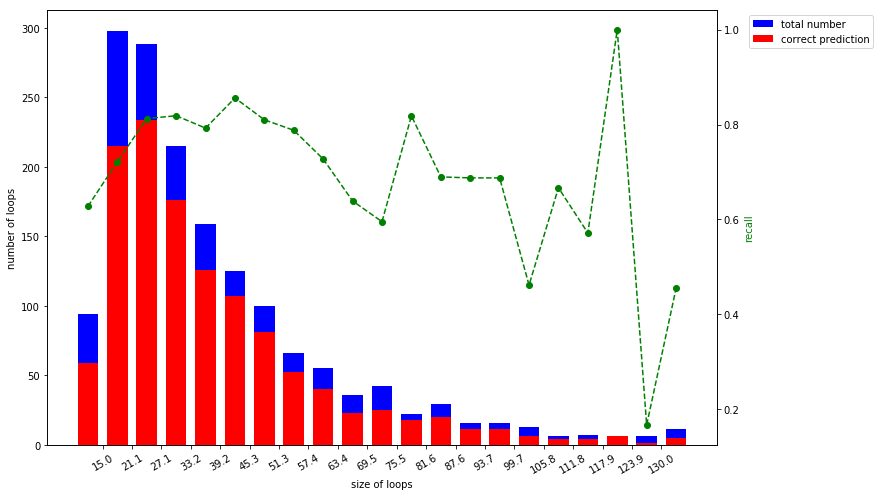

In [45]:
bins = 20
sz_range = (15,130)
recalls, precisions = evaluate_set_by_defect_size(model, dataset_test, num_bins=bins, size_range=sz_range, threshold=0.05)
pr_plot_by_size(recalls, label='recall', num_bins=bins, size_range=sz_range)

In [64]:
import os
print(os.getcwd())

/Users/mingrenshen/PycharmProjects/multitype-defect-detection
